# SARS strains and proteins co-occurence

## Protocol

Goal of this notebook is analysis co-occurence of different types, stains of SARS and SARS-related proteins and genes

We are using fantastic labeled dataset by SiBiteLabs:
https://github.com/SciBiteLabs/CORD19

### To do:
1. Buld dataframe from json-files. Output: data frame with columns ['paper_id','block_id','entity_type_1','..','entity_type_n']. Each row matchs a block. Block is a part of paper's abstract or full_text
2. Group SARS strains. Covid-19 is a main group. Output: lists of strains fo each grooup
3. Filter papers related to any of SARS group and build dataframe. Output: dataframe with columns ['paper_id','title','authors','year','SARS strain','CVPROT']. Each row matchs paper.
4. Plot piechart for strains grous: percent of papers (not blocks) mentioned each strains group. Histogram for strains: top 5 most mentioned strains across the groups.
5. Calculate and plot co-ocurence matrix for strains group and proteins (CVPROT). Calcultae andand plot co-ocurence matrix for top 5 most mentioned strains across and proteins (CVPROT). Use data from the block level(not paper)
6. Plot histogram: number of CVPROT mentioned at block level for SARS in general

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

import re

from tqdm import tqdm

import os
import json
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

## Helper functions

In [65]:
def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)
    
    return raw_files


def get_all_files(dirname):
    all_files = []
    
    filenames = os.listdir(dirname)

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        all_files.append(file)
    
    return all_files

def get_cat_vocab(cat):
    df_cat = df[cat]
    items = df_cat.dropna().tolist()

    vocab_list = []

    for element in items:
        item = element.split(",")
        for e in item:
            vocab_list.append(e)
    
    c = collections.Counter()

    for word in vocab_list:
        c[word] += 1
        
    result_dic = dict(c)
    
    return result_dic

#https://www.kaggle.com/rtatman/co-occurrence-matrix-plot-in-python
def df_co_occurrance(df, strain_group):
  strains_df = df.copy()  
  for i in strain_group:
        eval_match = df.SARS_COV.str.contains(i)
        strains_df[i] = eval_match
  return strains_df

## 1. Buld dataframe from json-files

In [3]:
#load all files
dirs = [
    'data/cord-19_annotated/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/',
    'data/cord-19_annotated/comm_use_subset/comm_use_subset/pdf_json/',
    'data/cord-19_annotated/custom_license/custom_license/pdf_json/',
    'data/cord-19_annotated/noncomm_use_subset/noncomm_use_subset/pdf_json/'
]

files_stack = []
for dir_ in dirs:
    files = get_all_files(dir_)
    files_stack.append(files)

100%|██████████| 2377/2377 [00:08<00:00, 271.22it/s]


In [4]:
#build list of entities types
c = collections.Counter()

cat_vocab = []

for files in tqdm(files_stack):
    for file in files:
        for block in file['body_text']:
            dict_file = block['termite_hits'].keys()
            for key in dict_file:
                cat_vocab.append(key)

for word in cat_vocab:
    c[word] += 1
   
vocab_list = (set(list(c.elements())))

100%|██████████| 4/4 [01:16<00:00, 15.12s/it]


In [5]:
vocab_list = sorted(list(vocab_list))
print(vocab_list)

['COUNTRY', 'CVPROT', 'DRUG', 'GENE', 'GOONTOL', 'HPO', 'INDICATION', 'SARSCOV', 'SPECIES']


In [6]:
#build dataframe: entity mentions by blocks ignoring hint count
features = []
for files in tqdm(files_stack):
    for file in files:
        paper_id = file['paper_id']
        
        i = 0
        sections = ['abstract', 'body_text']
        for section in sections:
            for block in file[section]:

                block_id = section + '_' + str(i)
                
                block_features = []
                block_features.append(paper_id)
                block_features.append(block_id)
                
                termite_hits = block['termite_hits']
                
                block_categories = termite_hits.keys()
                block_categories = list(block_categories)
                for cat in vocab_list:
        
                    if cat in block_categories:
                        cat_entities = []
                        for hit in termite_hits[cat]:
                            entity = hit.get('name')
                            if entity not in cat_entities:
                                cat_entities.append(entity)
                                
                        cat_entities = ",".join(cat_entities)

                    else:
                        cat_entities = None

                    block_features.append(cat_entities)

                features.append(block_features)
                i += 1


col_names = ['paper_id', 'block_id']
for cat in vocab_list:
    col_names.append(cat)
df = pd.DataFrame(features, columns=col_names)
df.head()

100%|██████████| 4/4 [02:51<00:00, 34.21s/it]


,paper_id,block_id,COUNTRY,CVPROT,DRUG,GENE,GOONTOL,HPO,INDICATION,SARSCOV,SPECIES
0,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,abstract_0,None,None,None,None,,None,"HIV Infections,Acquired Immunodeficiency Syndrome",retroviral integrase activity,"Virion,HIV-1,Viruses"
1,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,body_text_1,None,None,None,None,"virus maturation,viral replication,establishme...",None,"HIV Infections,Acquired Immunodeficiency Syndrome","retroviral 3' processing activity,retroviral i...","HIV-1,Viruses"
2,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,body_text_2,None,None,None,None,"antigen binding,binding",None,None,None,"Virion,Viruses"
3,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,body_text_3,None,None,Kuwanon L,PC4 and SFRS1 interacting protein 1,binding,None,HIV Infections,retroviral 3' processing activity,"Cats,HIV-1,Viruses"
4,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,body_text_4,None,None,None,None,None,None,None,None,None


In [7]:
#save data
df.to_csv('data/data_ner.csv')

## 2. Group SARS strains

In [8]:
vocab_sars = get_cat_vocab('SARSCOV')

In [9]:
vocab_sars

{'retroviral integrase activity': 666,
 "retroviral 3' processing activity": 28,
 'viral life cycle': 26007,
 'virion maturation': 420,
 'Severe acute respiratory syndrome coronavirus 2': 15294,
 'SARS coronavirus': 32512,
 '': 4365,
 'transmission of virus': 52614,
 'incubation period': 22303,
 'virus receptor activity': 2684,
 'viral release from host cell': 4666,
 'viral genome': 10635,
 'transport of virus': 1018,
 'viral nucleocapsid': 6408,
 'human-to-human viral transmission': 3031,
 'virion attachment to host cell': 1946,
 'modulation by virus of host morphology or physiology': 383,
 'viral process': 223,
 'viral membrane': 1797,
 'virion membrane': 330,
 'virus maturation': 402,
 'viral envelope': 3532,
 'viral gene expression': 911,
 'virion assembly': 2399,
 'SARS-CoV genome': 852,
 'viral transcription': 642,
 'viral capsid': 1646,
 'SARS coronavirus NS-1': 3402,
 'provirus': 567,
 'viral latency': 265,
 'viral strain': 6034,
 'SARS coronavirus Tor2': 343,
 'RNA viral genom

In [13]:
covid_19 = ['Severe acute respiratory syndrome coronavirus 2']

        
sars_genome = [
    'SARS coronavirus',
    'SARS-CoV genome'
]        
        
sars_strain_sin = [
    'SARS coronavirus SinP2',
    'SARS coronavirus Sin3408L',
    'SARS coronavirus SinP5',
    'SARS coronavirus SinP3',
    'SARS coronavirus SinP4',
    'SARS coronavirus Sin3408',
    'SARS coronavirus Sin3725V',
    'SARS coronavirus Sin0409',
    'SARS coronavirus Sin_WNV',
    'SARS coronavirus Sin2500',
    'SARS coronavirus Sin2677',
    'SARS coronavirus Sin2679',
    'SARS coronavirus Sin846',
    'SARS coronavirus Sin847',
    'SARS coronavirus Sin842',
    'SARS coronavirus Sin845',
    'SARS coronavirus Sin852',
    'SARS coronavirus Sin848',
    'SARS coronavirus Sin850',
    'SARS coronavirus Sin849',
    'SARS coronavirus Sino3-11',
    'SARS coronavirus Sin2748',
    'SARS coronavirus Sin2774',
]


sars_strain_a = [
    'SARS coronavirus A031',
    'SARS coronavirus A021',
    'SARS coronavirus A030',
    'SARS coronavirus A001',
    'SARS coronavirus A013',
    'SARS coronavirus A022',
]


sars_strain_tw = [
    'SARS coronavirus TW1',
    'SARS coronavirus TW11',
    'SARS coronavirus TW9',
    'SARS coronavirus TW8',
    'SARS coronavirus TW7',
    'SARS coronavirus TW3',
    'SARS coronavirus TW2',
    'SARS coronavirus TW6',
    'SARS coronavirus TW4',
    'SARS coronavirus TW5',
    'SARS coronavirus TW10',
]


sars_strain_pc4 = [
    'SARS coronavirus PC4-199',
    'SARS coronavirus PC4-241',
    'SARS coronavirus PC4-115',
    'SARS coronavirus PC4-227',
    'SARS coronavirus PC4-136',
    'SARS coronavirus PC4-205',
    'SARS coronavirus PC4-13',
    'SARS coronavirus PC4-137',
    'SARS coronavirus PC4-127',
]


sars_strain_hzs2 = [
    'SARS coronavirus HZS2-C',
    'SARS coronavirus HZS2-Fc',
    'SARS coronavirus HSZ-Bc',
    'SARS coronavirus HSZ-Bb',
    'SARS coronavirus HSZ-Cc',
    'SARS coronavirus HSZ2-A',
    'SARS coronavirus HZS2-E',
    'SARS coronavirus HZS2-D',
    'SARS coronavirus HSZ-A',
    'SARS coronavirus HZS2-C',
    'SARS coronavirus HZS2-Fc',
]


sars_strain_b = [
    'SARS coronavirus B033',
    'SARS coronavirus B029',
    'SARS coronavirus B040',
    'SARS coronavirus B039',
    'SARS coronavirus B024',
    'SARS coronavirus B012',
]

sars_strain_btrf = [
    'BtRf-BetaCoV/JL2012',
    'BtRf-BetaCoV/SX2013',
    'BtRf-BetaCoV/HeB2013',
    'BtRs-BetaCoV/YN2013',
    'BtRs-BetaCoV/GX2013',
    'BtRf-BetaCoV/JL2012',
    'BtRf-BetaCoV/SX2013',
    'BtRf-BetaCoV/HeB2013',
]    

sars_strain_c = [
    'SARS coronavirus C014',
    'SARS coronavirus C017',
    'SARS coronavirus C013',
    'SARS coronavirus C018',
    'SARS coronavirus C019',
    'SARS coronavirus C028',
    'SARS coronavirus C025',
]

sars_strain_bj = [
    'SARS coronavirus BJ302',
    'SARS coronavirus BJ03',
    'SARS coronavirus BJ202',
    'SARS coronavirus BJ02',
    'SARS coronavirus BJ04',
    'SARS coronavirus BJ182-12',
]

sars_strain_civet = [
    'SARS coronavirus civet014',
    'SARS coronavirus civet020',
    'SARS coronavirus civet010',
]

sars_strain_hku = [
    'SARS coronavirus HKU-39849',
    'SARS coronavirus HKU-65806',
]

sars_strain_lc = [
    'SARS coronavirus LC4',
    'SARS coronavirus LC3',
    'SARS coronavirus LC1',
    'SARS coronavirus LC2',
    'SARS coronavirus LC5',
    
]

sars_strain_twc = [
    'SARS coronavirus TWC',
    'SARS coronavirus TWC2',
    'SARS coronavirus TWC3',
    'SARS coronavirus Taiwan TC2',
    'SARS coronavirus Taiwan TC3',
    'SARS coronavirus Taiwan TC1',
    
]


sars_strain_gz = [
    'SARS coronavirus GZ60',
    'SARS coronavirus GZ0401',
    'SARS coronavirus GZ43',
    'SARS coronavirus GZ-A',
    'SARS coronavirus GZ50',
    'SARS coronavirus GZ-C',
    'SARS coronavirus GZ-B',
    'SARS coronavirus GZ0402',    
]

sars_strain_frankfurt = [
    'SARS coronavirus Frankfurt 1',
    'SARS coronavirus FRA',
]

sars_strain_cuhk = [
    'SARS coronavirus CUHK-AG02',
    'SARS coronavirus CUHK-AG03',
    'SARS coronavirus CUHK-L2',
    'SARS coronavirus CUHK-Su10',
    'SARS coronavirus CUHK-AG01',
]

sars_strain_gd = [
    'SARS coronavirus GD03T0013',
    'SARS coronavirus GD01',
    'SARS coronavirus GD69',
    'SARS coronavirus GD322',    
]    


sars_strain_pumc = [
    'SARS coronavirus PUMC01',
    'SARS coronavirus PUMC03',
    'SARS coronavirus PUMC02',    
]

sars_strain_zj = [
    'SARS coronavirus ZJ01',   
]

sars_strain_other = [
    'SARS coronavirus ZS-A',
    'SARS coronavirus WH20',
    'SARS coronavirus SoD',
    'SARS coronavirus ShanghaiQXC1',
    'SARS coronavirus ShanghaiQXC2',
    'SARS coronavirus ExoN1',
    'SARS coronavirus JMD',
    'SARS coronavirus ES191',
    'SARS coronavirus ZMY 1',
    'SARS coronavirus HGZ8L2',
    'SARS coronavirus HGZ8L1-A',
    'SARS coronavirus HSZ-Cb',
    'SARS coronavirus HZS2-Fb',    
    'SARS coronavirus ZS-B',
    'SARS coronavirus LLJ-2004',
    'SARS coronavirus Rs_672/2006',
    'SARS coronavirus Rs_672/2006',
    'SARS Coronavirus CDC#200301157',
    'SARS Coronavirus CDC#200301157'
    'SARS coronavirus HSR 1',
    'Bat SARS-like coronavirus WIV1',
    'SARS bat coronavirus',
    'SARS coronavirus GDH-BJH01',
    'SARS coronavirus HC/SZ/61/03',
    'SARS coronavirus AS',
    'SARS coronavirus wtic-MB',
    'SARS coronavirus SZ1',
    'SARS coronavirus SZ13',
]

sars = sars_genome + sars_strain_sin + sars_strain_a + sars_strain_tw + sars_strain_pc4 + sars_strain_hzs2 + sars_strain_b + sars_strain_btrf + sars_strain_c + sars_strain_bj +sars_strain_civet + sars_strain_hku + sars_strain_lc + sars_strain_twc + sars_strain_gz + sars_strain_frankfurt + sars_strain_cuhk + sars_strain_gd + sars_strain_pumc + sars_strain_zj + sars_strain_other

In [14]:
vocab_cvprot = get_cat_vocab('CVPROT')

In [15]:
vocab_cvprot

{'SPIKE_CVHSA': 10329,
 'NCAP_CVHSA': 4960,
 'VME1_CVHSA': 2230,
 'AP3A_CVHSA': 349,
 'VEMP_CVHSA': 2258,
 'Y14_CVHSA': 25,
 'ORF9B_CVHSA': 165,
 'R1A_CVHSA': 2993,
 'R1AB_CVHSA': 3095,
 'NS6_CVHSA': 255,
 '': 21,
 'NS7B_CVHSA': 67,
 'NS3B_CVHSA': 90,
 'NS7A_CVHSA': 93,
 'NS8A_CVHSA': 33,
 'NS8B_CVHSA': 20}

In [16]:
vocab_genes = get_cat_vocab('GENE')

In [17]:
vocab_genes

{'PC4 and SFRS1 interacting protein 1': 27,
 'ATP/GTP binding protein like 1': 144,
 'angiotensin I converting enzyme 2': 6575,
 'transmembrane protease': 1477,
 ' serine 2': 823,
 'dipeptidyl peptidase 4': 2908,
 'ST6 beta-galactoside alpha-2': 135,
 '6-sialyltransferase 1': 149,
 'cathepsin L': 844,
 'alanyl aminopeptidase': 1541,
 ' membrane': 1541,
 'ST3 beta-galactoside alpha-2': 75,
 '3-sialyltransferase 4': 16,
 'furin': 1381,
 ' paired basic amino acid cleaving enzyme': 1381,
 'cathepsin B': 807,
 ' serine 11D': 101,
 'DNA topoisomerase II alpha': 39,
 'achaete-scute family bHLH transcription factor 3': 3,
 'keratin 5': 62,
 'achaete-scute family bHLH transcription factor 1': 11,
 'G protein subunit gamma 13': 4,
 'TYRO protein tyrosine kinase binding protein': 157,
 'G protein subunit gamma 8': 3,
 "5\\'-nucleotidase ecto": 91,
 'inositol 1': 103,
 '4': 106,
 '5-trisphosphate receptor type 3': 34,
 'forkhead box L1': 3,
 'transient receptor potential cation channel subfamily M

In [18]:
vocab_hpo = get_cat_vocab('HPO')

In [19]:
vocab_hpo

{'Anosmia': 92,
 'Parageusia': 28,
 'Respiratory distress': 2956,
 'Hyposmia': 61,
 '': 37956,
 'Pneumonia': 24919,
 'Myopathy': 434,
 'Increased reactive oxygen species production': 2767,
 'Alopecia': 944,
 'Palpebral edema': 66,
 'Papilloma': 549,
 'T-cell lymphoma': 306,
 'Functional respiratory abnormality': 5134,
 'Recurrent lower respiratory tract infections': 2505,
 'Diarrhea': 24218,
 'Intermittent diarrhea': 82,
 'Respiratory tract infection': 11847,
 'Allergy': 7061,
 'Fever': 26441,
 'Elevated hepatic transaminase': 620,
 'Abnormal liver physiology': 69,
 'Cough': 12688,
 'Productive cough': 1295,
 'Breathing dysregulation': 243,
 'Hepatic steatosis': 566,
 'Nonproductive cough': 960,
 'Elevated C-reactive protein level': 238,
 'Myalgia': 2948,
 'Inflammation of the large intestine': 1145,
 'Hypertension': 3336,
 "Crohn's disease": 653,
 'Respiratory failure': 3097,
 'Autoimmunity': 7926,
 'Systemic lupus erythematosus': 798,
 'Rheumatoid arthritis': 1371,
 'Breast carcinoma

## 3. Filter Papers, Create DataFrame

In [20]:
#https://www.kaggle.com/maksimeren/covid-19-literature-clustering


In [21]:
data = df.fillna('qqqqq')

In [22]:
data['CVPROT'].value_counts()

qqqqq                                                                 1309117
SPIKE_CVHSA                                                              7699
NCAP_CVHSA                                                               2827
R1A_CVHSA,R1AB_CVHSA                                                     2488
VEMP_CVHSA                                                               1025
NCAP_CVHSA,SPIKE_CVHSA                                                    787
VME1_CVHSA                                                                657
SPIKE_CVHSA,VME1_CVHSA                                                    341
NCAP_CVHSA,SPIKE_CVHSA,VME1_CVHSA,VEMP_CVHSA                              269
SPIKE_CVHSA,VEMP_CVHSA                                                    242
NCAP_CVHSA,VME1_CVHSA                                                     237
NCAP_CVHSA,SPIKE_CVHSA,VME1_CVHSA                                         236
AP3A_CVHSA                                                      

In [26]:
#create cvprot list

cvprot_list = sorted(list(vocab_cvprot.keys()))
cvprot_list = cvprot_list[1:] #filter na
cvprot_list

['AP3A_CVHSA',
 'NCAP_CVHSA',
 'NS3B_CVHSA',
 'NS6_CVHSA',
 'NS7A_CVHSA',
 'NS7B_CVHSA',
 'NS8A_CVHSA',
 'NS8B_CVHSA',
 'ORF9B_CVHSA',
 'R1AB_CVHSA',
 'R1A_CVHSA',
 'SPIKE_CVHSA',
 'VEMP_CVHSA',
 'VME1_CVHSA',
 'Y14_CVHSA']

In [28]:
sars_paper_id = {'PAPER_ID': [], 'SARS_COV': [],'STRAINS_GROUP': [],'SPECIES': [],'CVPROT': []}
for i in tqdm(range(0, data.shape[0])):
    row = data.iloc[i]
    prot_field = row['CVPROT']
    prot_field = str(prot_field)
    prot_field = prot_field.split(',')
    for prot in prot_field:
        if prot in cvprot_list:
            paper_id = row['paper_id']
            SARS_cov = row['SARSCOV']
            species = row['SPECIES']
            sars_paper_id['PAPER_ID'].append(paper_id)
            sars_paper_id['SARS_COV'].append(SARS_cov)
            sars_paper_id['SPECIES'].append(species)
            sars_paper_id['CVPROT'].append(prot)
    
  
df_cvprot = pd.DataFrame(sars_paper_id, columns=['PAPER_ID', 'SARS_COV', 'SPECIES', 'CVPROT'])
df_cvprot.head()

100%|██████████| 1328146/1328146 [03:33<00:00, 6224.18it/s]


,PAPER_ID,SARS_COV,SPECIES,CVPROT
0,7cfaa2540d3c8eea0982b3b1147884f125f67ff2,SARS coronavirus,"SARS Virus,Humans,Viruses",SPIKE_CVHSA
1,9bbfd3d34ee18ea1b9f4669331a6cee9c5992893,Severe acute respiratory syndrome coronavirus 2,"Humans,Viruses",SPIKE_CVHSA
2,9bbfd3d34ee18ea1b9f4669331a6cee9c5992893,"SARS coronavirus,Severe acute respiratory synd...","SARS Virus,Viruses",SPIKE_CVHSA
3,9bbfd3d34ee18ea1b9f4669331a6cee9c5992893,Severe acute respiratory syndrome coronavirus 2,"Coronavirus NL63, Human",SPIKE_CVHSA
4,240da1ff435355a853d5c830f78751aff5f51fd1,"viral genome,Severe acute respiratory syndrome...",Nucleocapsid,NCAP_CVHSA


In [29]:
df_cvprot.shape

(26962, 4)

In [30]:
#save data
df_cvprot.to_csv('data/data_prot.csv')

## 4. Create Pie Chart, Histogram

In [31]:
#check data unique relation - paper ID & protein
df_paper_id = df_cvprot["PAPER_ID"]
df_prot = df_cvprot["CVPROT"]
df_check_unq = pd.concat([df_paper_id, df_prot], axis=1)

In [32]:
df_check_unq.shape
df_check_unq = df_check_unq.drop_duplicates()
df_check_unq.shape

(10404, 2)

In [33]:
#Plot piechart for strains groups: percent of papers (not blocks) mentioned each strains group. 
#IMPORTANT: STRAINS or PROTEINS? This is proteins.
#get count of papers that contain at least one mention of the protein
prot_counts = df_check_unq.groupby('CVPROT').CVPROT.value_counts()
prot_counts

CVPROT       CVPROT     
AP3A_CVHSA   AP3A_CVHSA      134
NCAP_CVHSA   NCAP_CVHSA     2136
NS3B_CVHSA   NS3B_CVHSA       55
NS6_CVHSA    NS6_CVHSA       147
NS7A_CVHSA   NS7A_CVHSA       59
NS7B_CVHSA   NS7B_CVHSA       37
NS8A_CVHSA   NS8A_CVHSA       19
NS8B_CVHSA   NS8B_CVHSA       11
ORF9B_CVHSA  ORF9B_CVHSA      69
R1AB_CVHSA   R1AB_CVHSA      925
R1A_CVHSA    R1A_CVHSA       839
SPIKE_CVHSA  SPIKE_CVHSA    3537
VEMP_CVHSA   VEMP_CVHSA     1129
VME1_CVHSA   VME1_CVHSA     1296
Y14_CVHSA    Y14_CVHSA        11
Name: CVPROT, dtype: int64

In [35]:
#get total paper count
papers = df_cvprot["PAPER_ID"]
papers.shape[0]
papers = papers.drop_duplicates()
papers.shape[0]
total_papers = papers.shape[0]
total_papers

5352

In [41]:
#get sorted listed of proteins
proteins = df_cvprot.CVPROT.value_counts()
proteins = list(proteins.index)
proteins = pd.Series(proteins)
proteins = proteins.sort_values().reset_index()
proteins = pd.DataFrame(proteins)
proteins = proteins.iloc[:,1]
proteins

0      AP3A_CVHSA
1      NCAP_CVHSA
2      NS3B_CVHSA
3       NS6_CVHSA
4      NS7A_CVHSA
5      NS7B_CVHSA
6      NS8A_CVHSA
7      NS8B_CVHSA
8     ORF9B_CVHSA
9      R1AB_CVHSA
10      R1A_CVHSA
11    SPIKE_CVHSA
12     VEMP_CVHSA
13     VME1_CVHSA
14      Y14_CVHSA
Name: 0, dtype: object

In [43]:
protein_counts = prot_counts.values.tolist()
protein_counts

[134, 2136, 55, 147, 59, 37, 19, 11, 69, 925, 839, 3537, 1129, 1296, 11]

In [50]:
pie_chart_input = {'protein': [], 'percent': []}
for i in range(0,proteins.shape[0]):
  label = proteins.iloc[i]
  value = protein_counts[i]
  percent = round(value/total_papers,2)*100
  pie_chart_input['protein'].append(label)
  pie_chart_input['percent'].append(percent)

pie_chart_input = pd.DataFrame(pie_chart_input)
pie_chart_input = pie_chart_input.sort_values(by='percent', ascending=False)
pie_chart_input

,protein,percent
11,SPIKE_CVHSA,66.0
1,NCAP_CVHSA,40.0
13,VME1_CVHSA,24.0
12,VEMP_CVHSA,21.0
9,R1AB_CVHSA,17.0
10,R1A_CVHSA,16.0
0,AP3A_CVHSA,3.0
3,NS6_CVHSA,3.0
2,NS3B_CVHSA,1.0
4,NS7A_CVHSA,1.0


In [51]:
#use only top 6 for pie chart
input = pie_chart_input.iloc[0:6]
input

,protein,percent
11,SPIKE_CVHSA,66.0
1,NCAP_CVHSA,40.0
13,VME1_CVHSA,24.0
12,VEMP_CVHSA,21.0
9,R1AB_CVHSA,17.0
10,R1A_CVHSA,16.0


In [53]:
#sum the rest
labels = list(input.iloc[:,0])
labels[-1] = 'Other'
labels

['SPIKE_CVHSA',
 'NCAP_CVHSA',
 'VME1_CVHSA',
 'VEMP_CVHSA',
 'R1AB_CVHSA',
 'Other']

In [56]:
other = pie_chart_input.iloc[7:,1].sum()
sizes = list(input.iloc[:,1])
sizes[-1] = other
sizes

[66.0, 40.0, 24.0, 21.0, 17.0, 7.0]

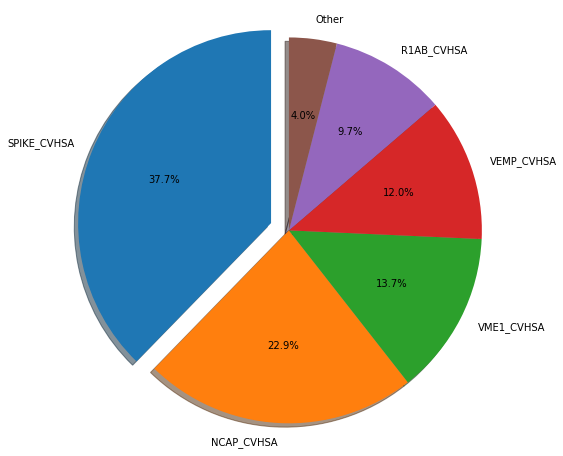

In [57]:
#Pie Chart - Adjust labels, sizes & explode after running on full data
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = labels
sizes = sizes
explode = (0.1, 0.0, 0, 0,0,0)  # only "explode" the 1st slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

In [61]:
#Do the same for strains?

#get sorted listed
strains = df_cvprot.SARS_COV.value_counts()
strains = list(strains.index)
strains = pd.Series(strains)
strains = proteins.sort_values().reset_index()
strains = pd.DataFrame(strains)
strains = strains.iloc[:,1]

strains_counts = df_check_unq.groupby('SARS_COV').SARS_COV.value_counts()
strains_counts = prot_counts.values.tolist()

In [ ]:
#Histogram for strains: top 5 most mentioned strains across the groups (includes multiple counts in one paper)

#IMPORTANT: STRAINS or PROTEINS???
#This is proteins.


In [58]:
cvprot_counts = df_cvprot['CVPROT'].value_counts()

Text(0, 0.5, 'protein')

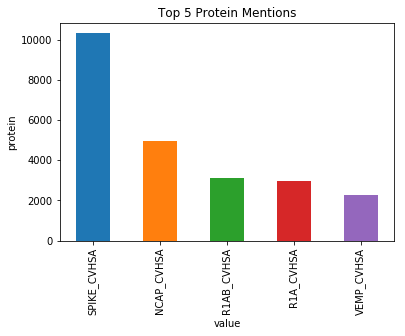

In [59]:
cvprot_counts
top_5 = cvprot_counts[0:5]
top_5
top_5.plot(kind='bar')
plt.title('Top 5 Protein Mentions')
plt.xlabel('value')
plt.ylabel('protein')

In [ ]:
#Do the same for strains?


## 4. Get Strain Count Data, Create HeatMaps of Strains

In [63]:
df_cvprot.shape[0], df_cvprot.PAPER_ID.nunique()  # <check the input data is block level.

(26962, 5352)

In [66]:
# repeat for all strain groups
strains_df = df_co_occurrance(df_cvprot,covid_19)

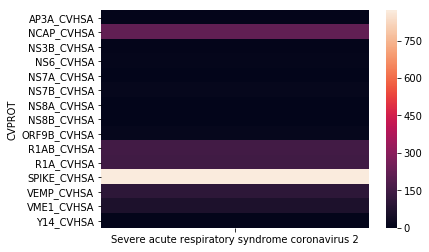

In [67]:
#transform data and create heatmap (repeat for all strain groups)
strains_df.iloc[:,4:] = strains_df.iloc[:,4:].astype(int) 
strains_df = strains_df.iloc[:,3:]
prot_strains_grpd = strains_df.groupby('CVPROT').sum()
sns.heatmap(prot_strains_grpd)